In [1]:
import pandas as pd

from math import pi
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

pd.options.display.max_rows = 100

In [2]:
def run_cluster(data, num_clusters=5):
    # create kmeans model
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(data)

    # find centers and labels
    centers = kmeans.cluster_centers_
    labels = kmeans.labels_

    # DataFrame of centroids
    centroids_df = pd.DataFrame(centers, columns=data.columns).T

    # print items in clusters
    clusters = {}
    for i in range(len(labels)):
        clusters[players[i]] = labels[i]

    for i in range(len(centers)):
        out = [k for k,v in clusters.items() if v==i]

        print('-'*30)
        print(f'cluster index: {i}')
        for item in out:
            print(item)
        print('\n')

#     centroids_df.to_csv('final_clusters.csv')
    return clusters, centroids_df


In [3]:
data = pd.read_csv('Data/nba_data.csv')
players = data.player.to_list()


In [4]:
# nba_data = nba_data.set_index('rank')
nba_data = data.drop(['Unnamed: 0', 'player', 'pos', 'team_id', 'age', 'mp', 'fg', 'fga','fg3',
 'fg3a','fg2',
 'fg2a','ft',
 'fta','orb',
 'drb',
 'trb',
 'ast',
 'stl',
 'blk',
 'tov',
 'pf',
 'pts',], axis=1)


In [5]:
clusters, centroids_df = run_cluster(nba_data, 8)

------------------------------
cluster index: 0
Bam Adebayo
Ryan Arcidiacono
Marvin Bagley
Malik Beasley
Davis Bertans
Miles Bridges
Jaylen Brown
Kentavious Caldwell-Pope
Zach Collins
Torrey Craig
Dante Cunningham
Ed Davis
Gorgui Dieng
Dorian Finney-Smith
Montrezl Harrell
Gordon Hayward
Juan Hernangomez
Richaun Holmes
Andre Iguodala
Ersan Ilyasova
Jonas Jerebko
Derrick Jones
Maxi Kleber
Jake Layman
Alex Len
Kevon Looney
Robin Lopez
Alfonzo McKinnie
Monte Morris
Larry Nance
Nerlens Noel
Royce O'Neale
Jahlil Okafor
Kelly Olynyk
Zaza Pachulia
Mason Plumlee
Jakob Poetl
Dwight Powell
Mitchell Robinson
Domantas Sabonis
Tony Snell
Daniel Theis
Ante Zizic
James Ennis
JaMychal Green
Justin Jackson
Enes Kanter
Dario Saric
Landry Shamet
Delon Wright


------------------------------
cluster index: 1
Bradley Beal
Eric Bledsoe
Bojan Bogdanovic
Devin Booker
Mike Conley
Stephen Curry
DeMar DeRozan
Luka Doncic
Kevin Durant
Evan Fournier
De'Aaron Fox
Danilo Gallinari
Paul George
Aaron Gordon
Blake Griff

In [60]:
def plot_radar(headers, input_values, title='test', fill_color='k', edge_color=None):
    values = input_values.copy()
    values += values [:1]

    angles = [n / float(len(headers)) * 2 * pi for n in range(len(headers))]
    angles += angles [:1]

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, polar=True)

    plt.xticks(angles[:-1], headers)

    ax.plot(angles, values)

    ax.fill(angles, values, facecolor=fill_color, edgecolor=edge_color, alpha=0.4)
#     ax.fill(angles, values, 'teal', alpha=0.1)

    ax.set_title(title)
    plt.show()


In [7]:
player_df = data[['player', 'team_id']]
player_df

test_df = pd.DataFrame([clusters]).T.reset_index()
test_df = test_df.rename(columns={'index':'player', 0:'cluster'})

test_df

player_type_df = player_df.merge(test_df, on='player')
player_type_df

player_type_df.sort_values(by='team_id')


,player,team_id,cluster
143,Daniel Hamilton,ATL,2
27,Kent Bazemore,ATL,7
33,DeAndre' Bembry,ATL,6
68,Vince Carter,ATL,6
76,John Collins,ATL,5
...,...,...,...
60,Thomas Bryant,WAS,5
58,Troy Brown,WAS,6
294,Tomas Satoransky,WAS,4
28,Bradley Beal,WAS,1


In [8]:
player_type_df.team_id.unique()

array(['OKC', 'ATL', 'MIA', 'SAS', 'UTA', 'BRK', 'NYK', 'POR', 'MEM',
       'MIL', 'HOU', 'TOR', 'CHI', 'ORL', 'PHO', 'CHO', 'SAC', 'LAL',
       'DAL', 'DEN', 'MIN', 'BOS', 'WAS', 'GSW', 'LAC', 'CLE', 'IND',
       'PHI', 'DET', 'NOP', 'TOT'], dtype=object)

In [9]:
test_df = player_type_df.loc[player_type_df.team_id != 'TOT']
test_df.team_id.unique()


array(['OKC', 'ATL', 'MIA', 'SAS', 'UTA', 'BRK', 'NYK', 'POR', 'MEM',
       'MIL', 'HOU', 'TOR', 'CHI', 'ORL', 'PHO', 'CHO', 'SAC', 'LAL',
       'DAL', 'DEN', 'MIN', 'BOS', 'WAS', 'GSW', 'LAC', 'CLE', 'IND',
       'PHI', 'DET', 'NOP'], dtype=object)

In [10]:
test_df


,player,team_id,cluster
0,Alex Abrines,OKC,2
1,Jaylen Adams,ATL,2
2,Steven Adams,OKC,5
3,Bam Adebayo,MIA,0
4,LaMarcus Aldridge,SAS,5
...,...,...,...
346,Guerschon Yabusele,BOS,2
347,Thaddeus Young,IND,4
348,Trae Young,ATL,1
349,Cody Zeller,CHO,7


[1, 2, 3, 1, 2, 1, 3]

In [63]:
test_df = player_type_df.loc[player_type_df.team_id == 'ATL']

cluster_count = test_df.groupby(['cluster']).count()['player'].to_list()
headers = [f'cluster {x}' for x in range(len(cluster_count))]


print(headers)
print(cluster_count)


['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3', 'cluster 4', 'cluster 5', 'cluster 6', 'cluster 7']
[1, 1, 4, 1, 2, 1, 2, 2]


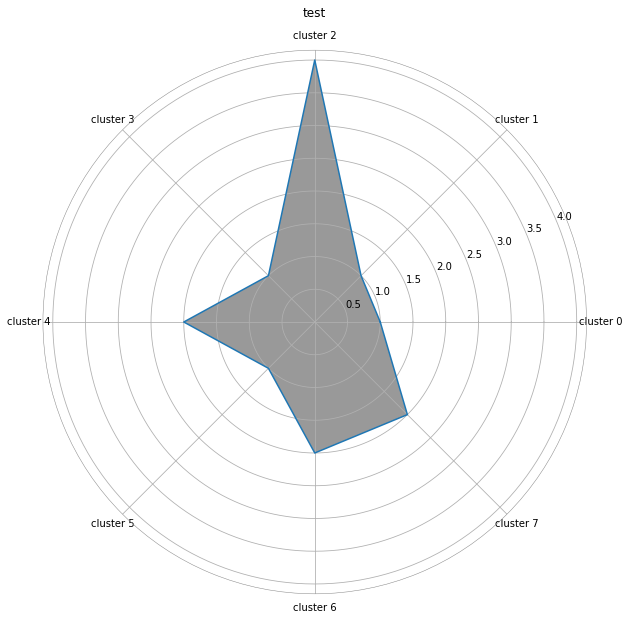

In [64]:
plot_radar(headers, cluster_count, 'test')

In [65]:
def plot_team(team):
    test_df = player_type_df.loc[player_type_df.team_id == team]

    cluster_count = test_df.groupby(['cluster']).count()['player'].to_list()
    headers = [f'cluster {x}' for x in range(len(cluster_count))]

    plot_radar(headers, cluster_count, f'player dist for {team}')


array(['OKC', 'ATL', 'MIA', 'SAS', 'UTA', 'BRK', 'NYK', 'POR', 'MEM',
       'MIL', 'HOU', 'TOR', 'CHI', 'ORL', 'PHO', 'CHO', 'SAC', 'LAL',
       'DAL', 'DEN', 'MIN', 'BOS', 'WAS', 'GSW', 'LAC', 'CLE', 'IND',
       'PHI', 'DET', 'NOP', 'TOT'], dtype=object)

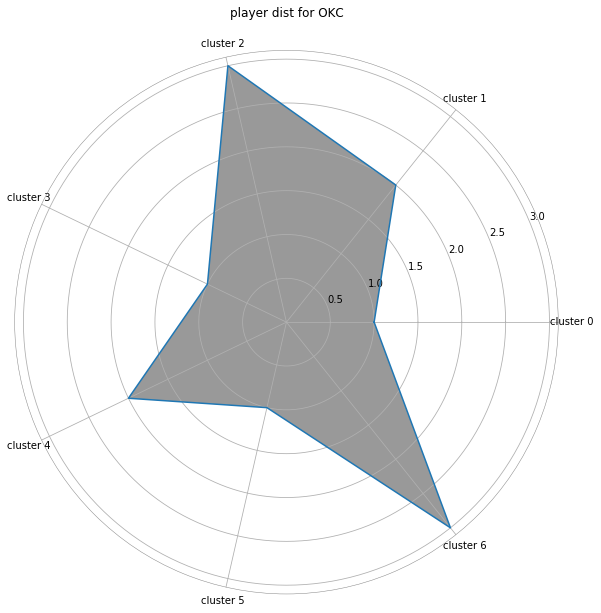

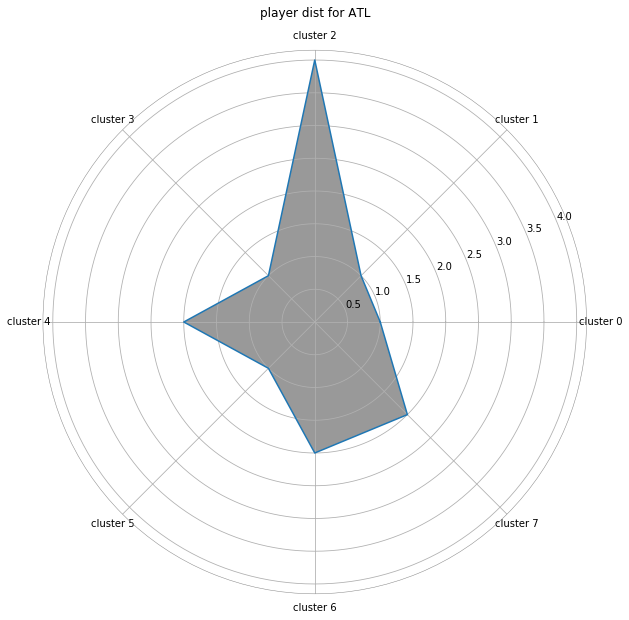

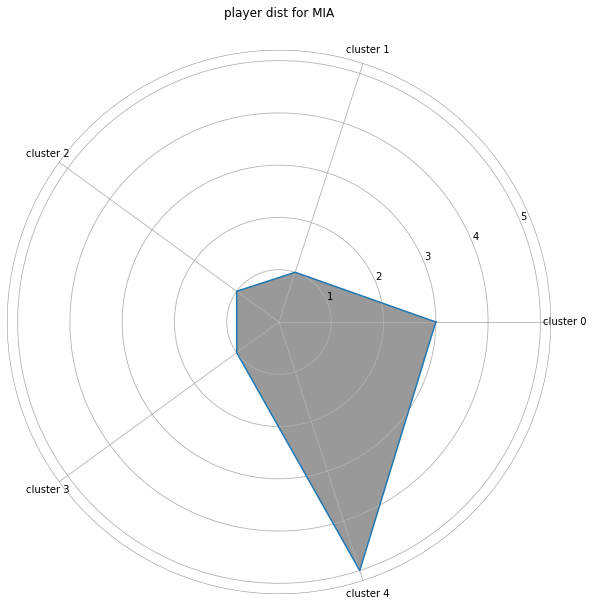

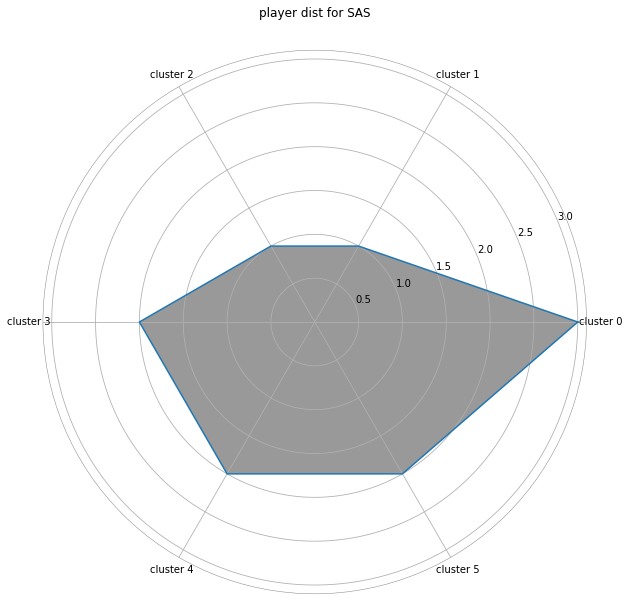

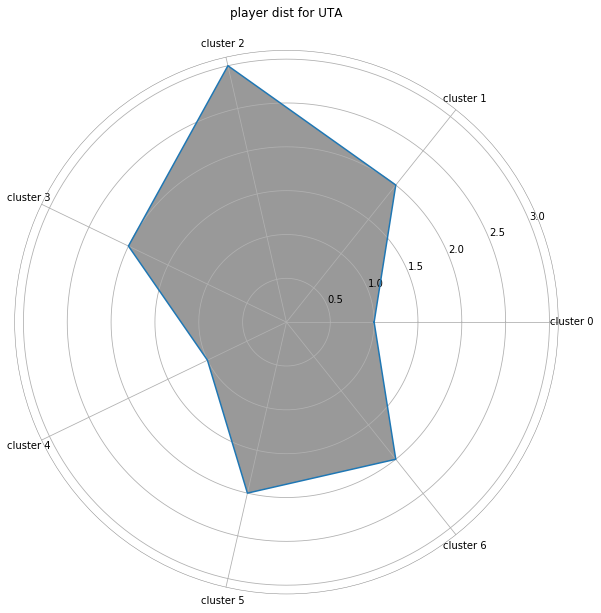

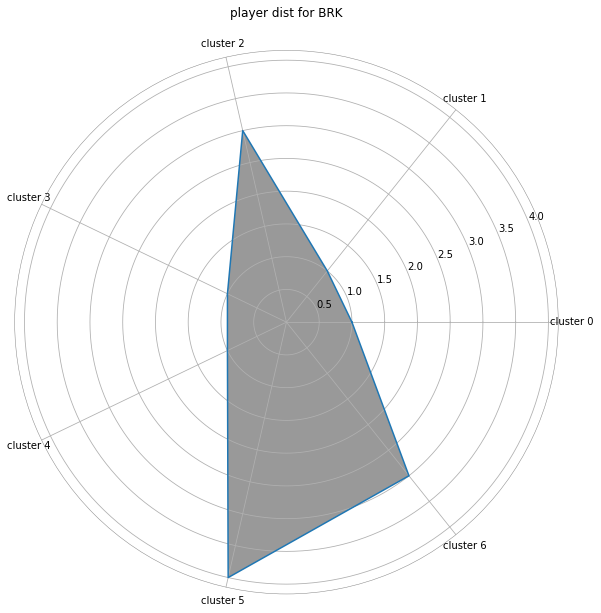

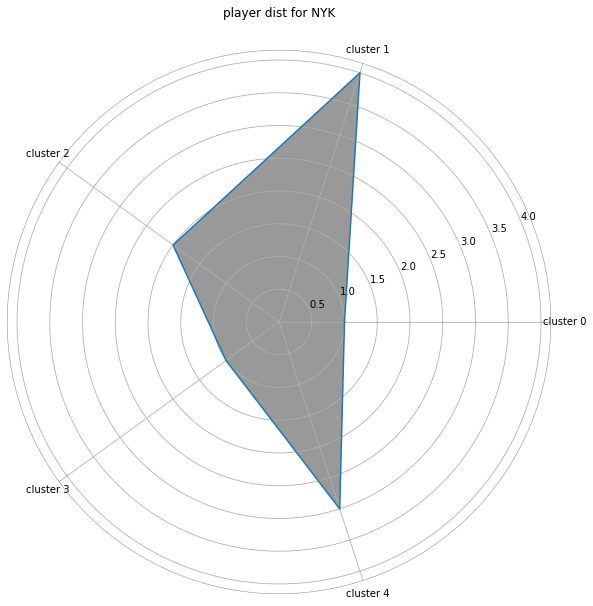

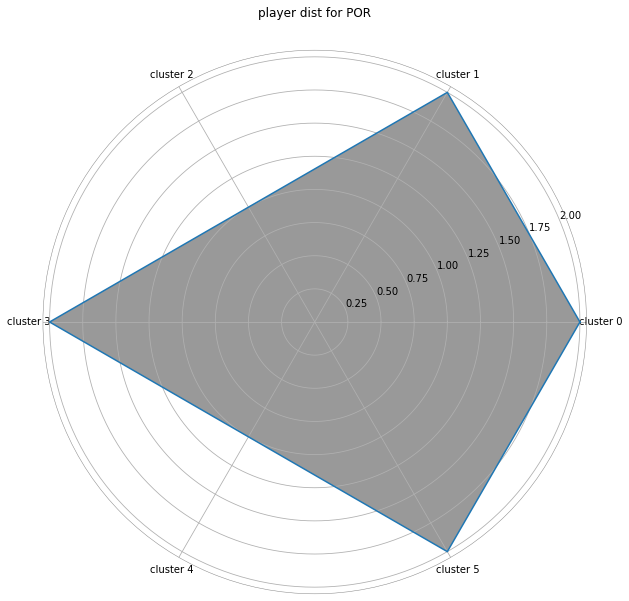

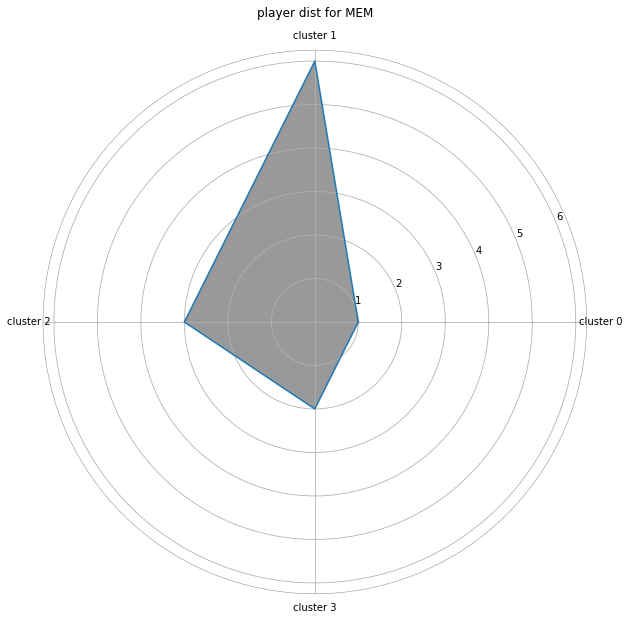

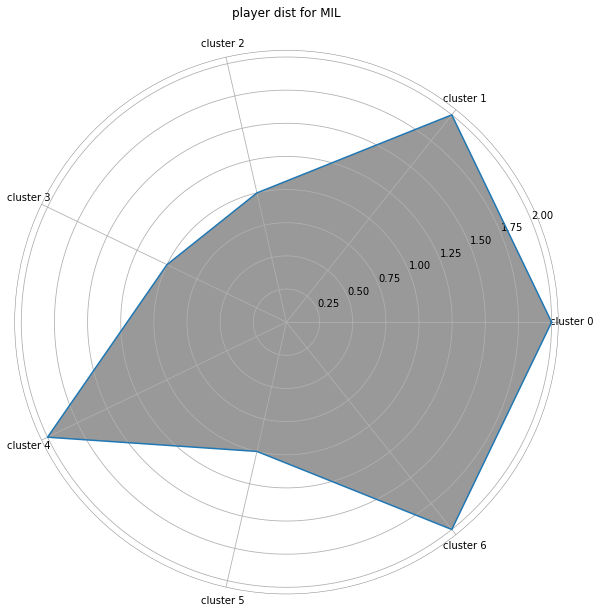

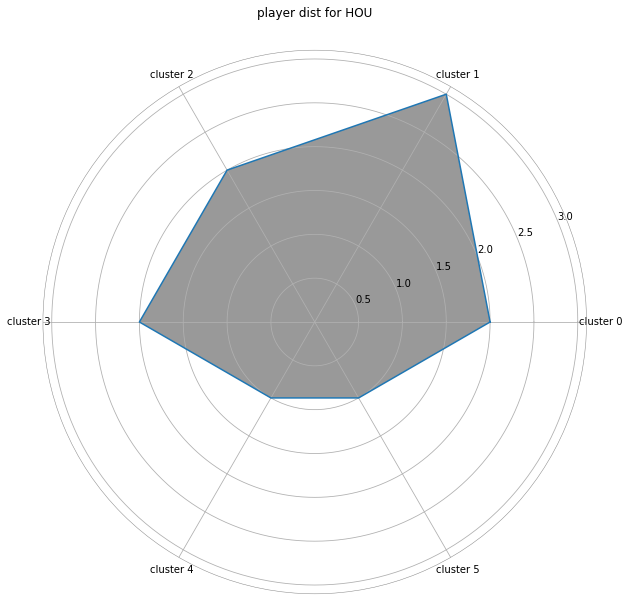

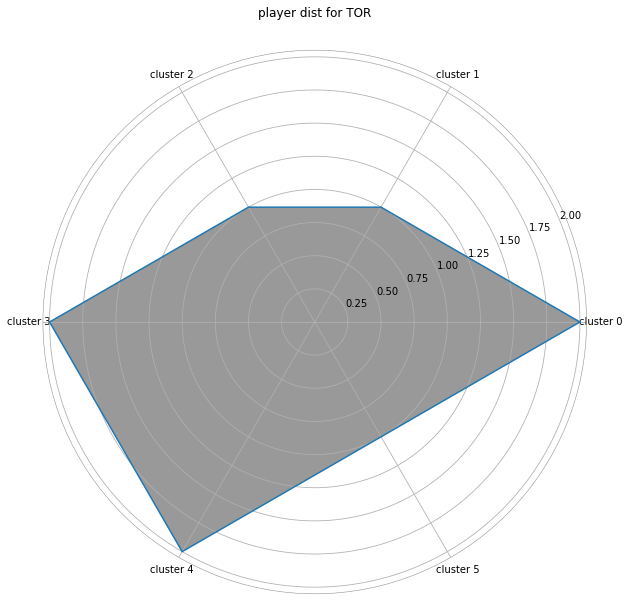

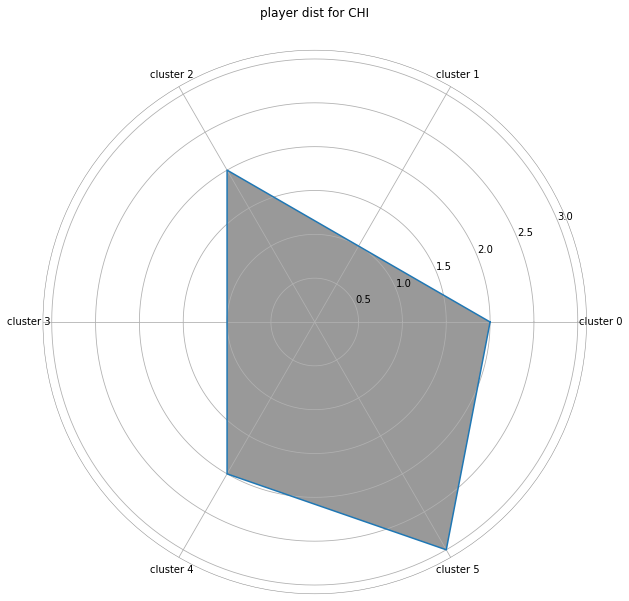

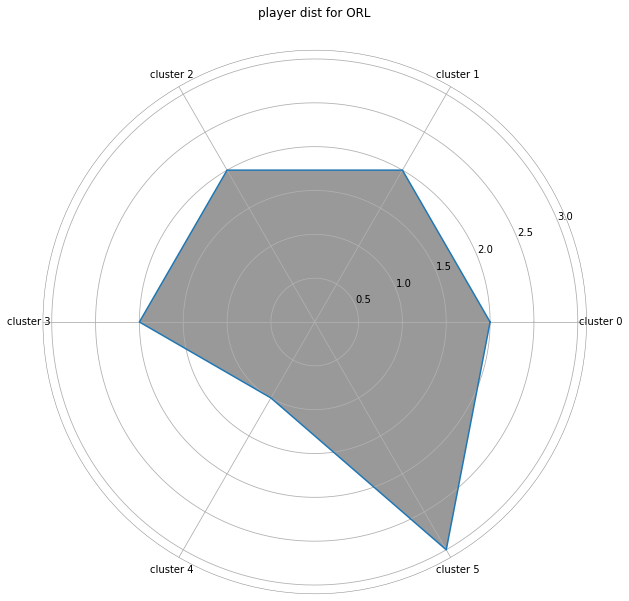

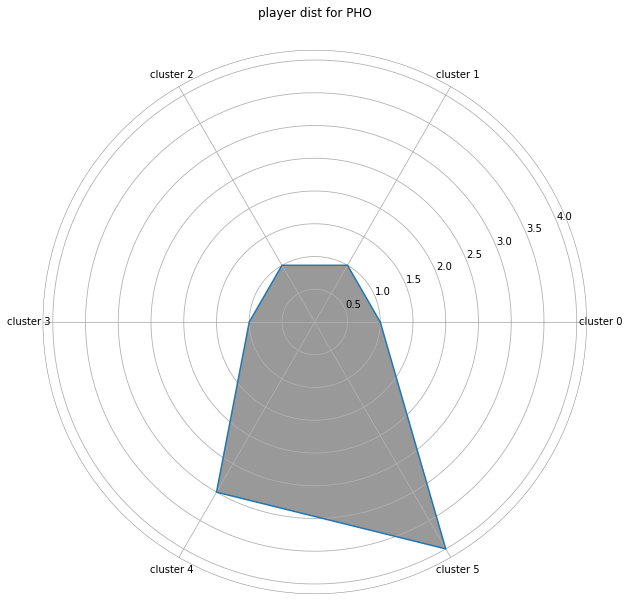

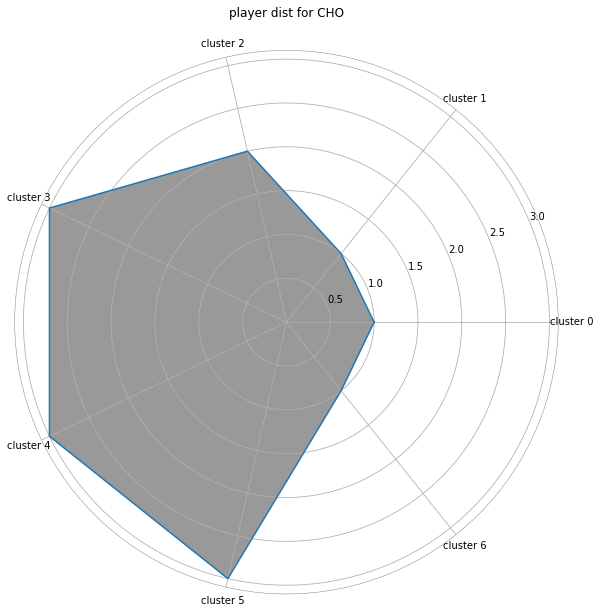

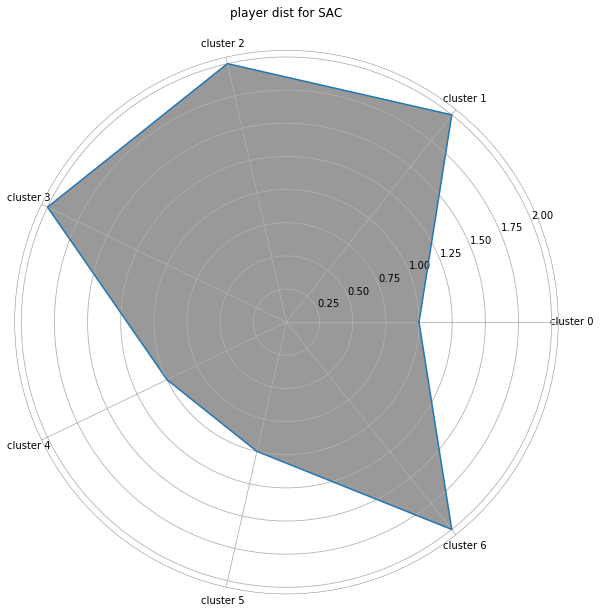

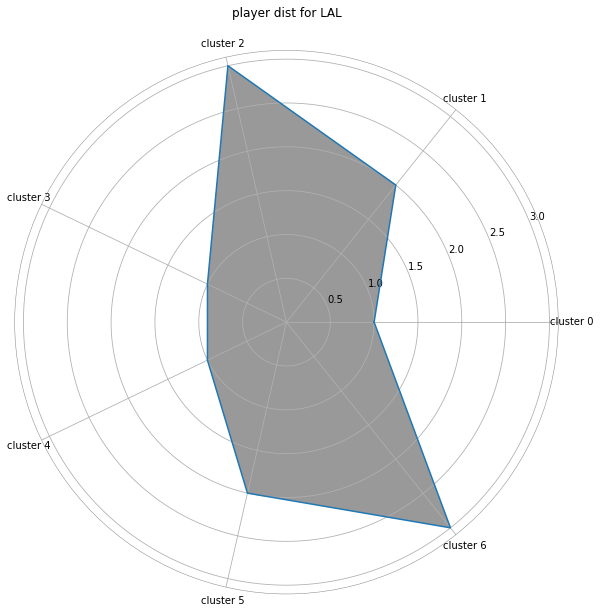

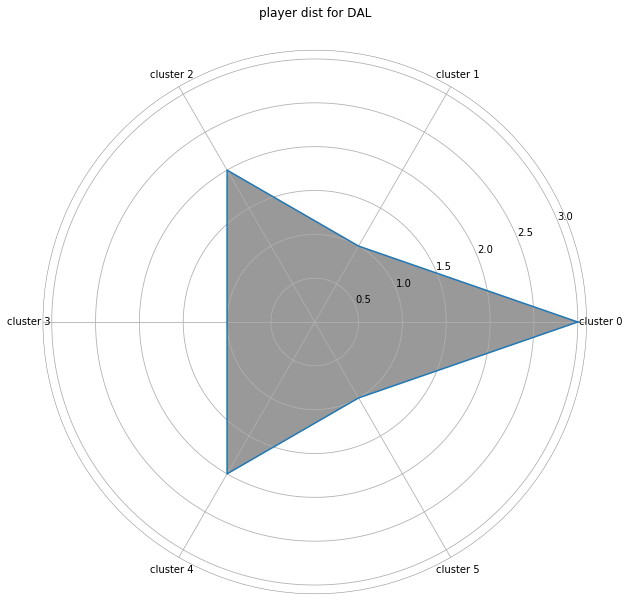

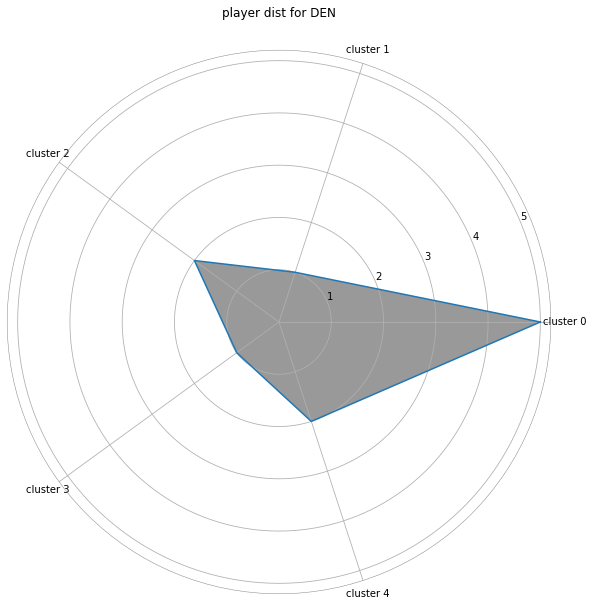

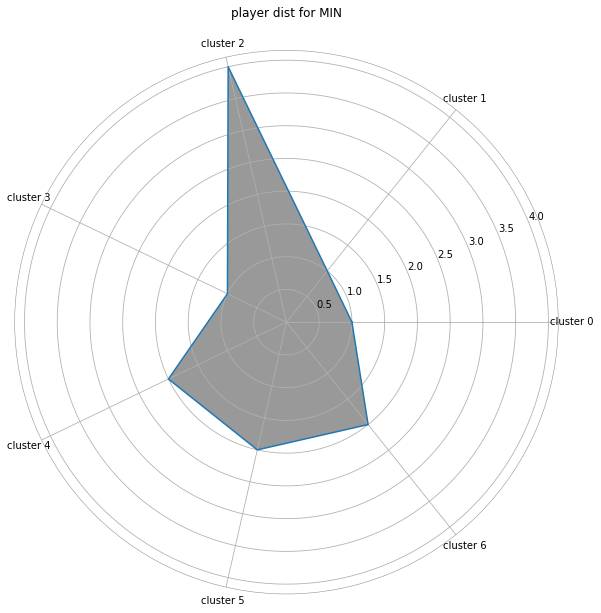

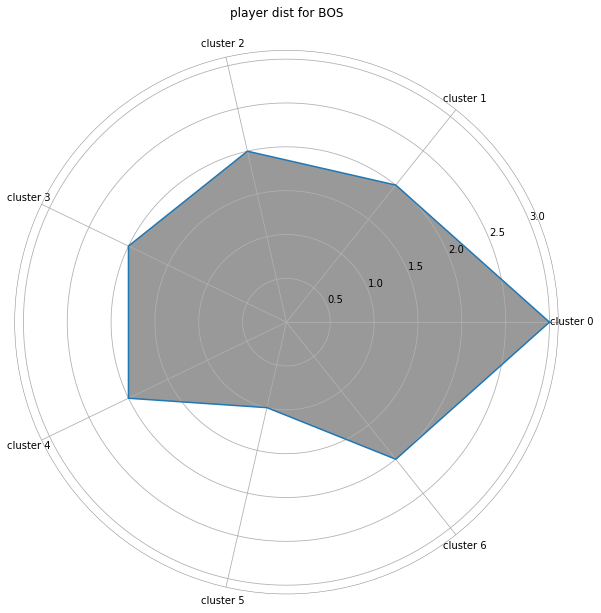

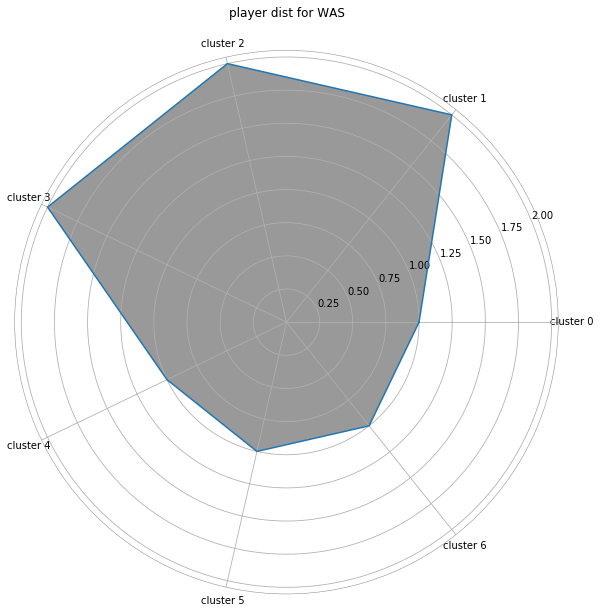

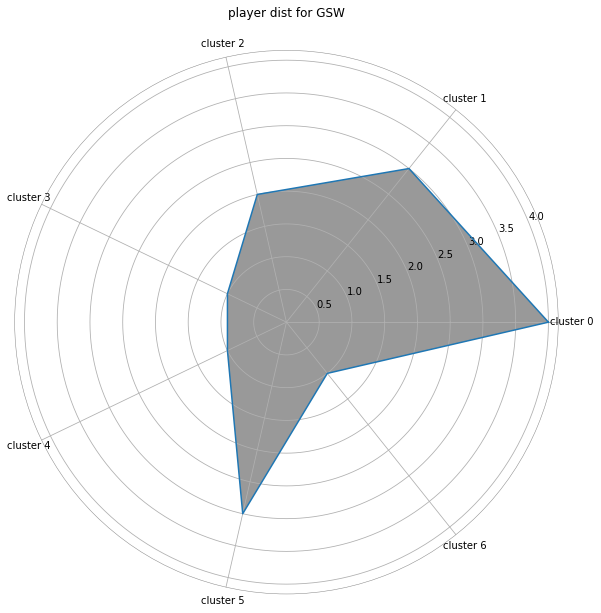

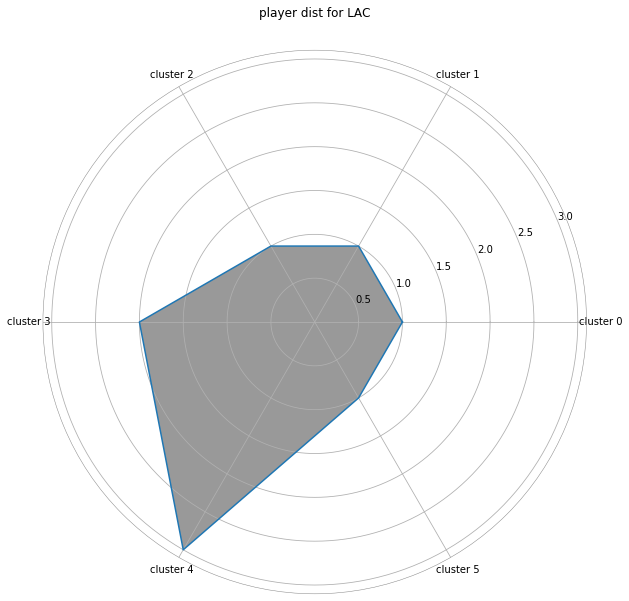

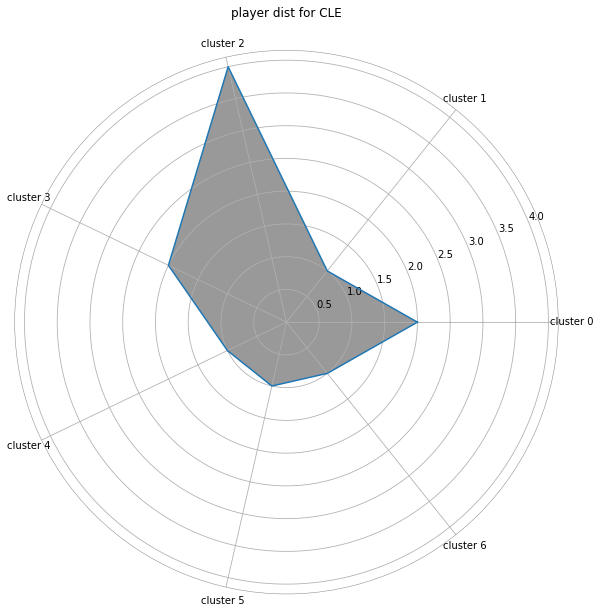

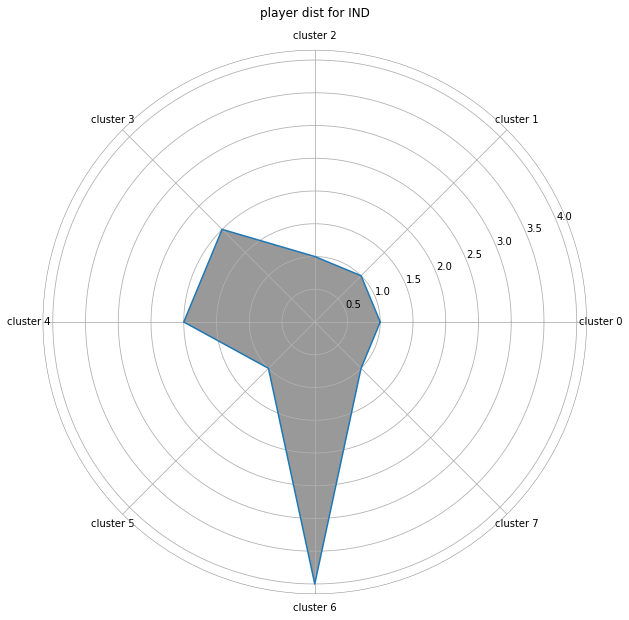

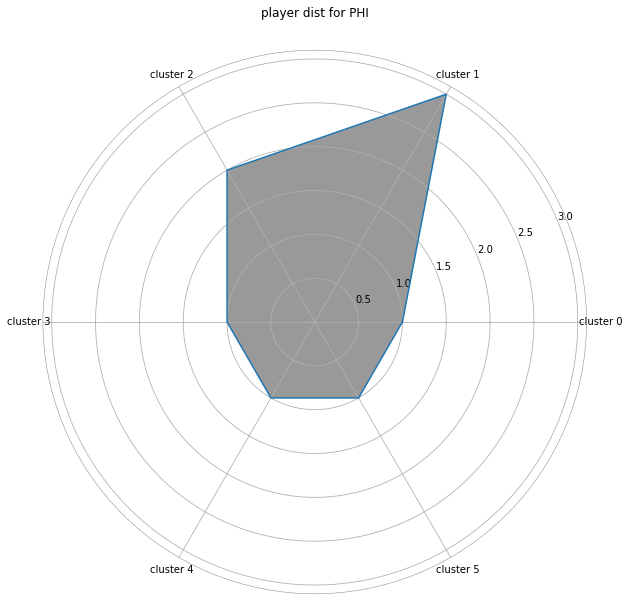

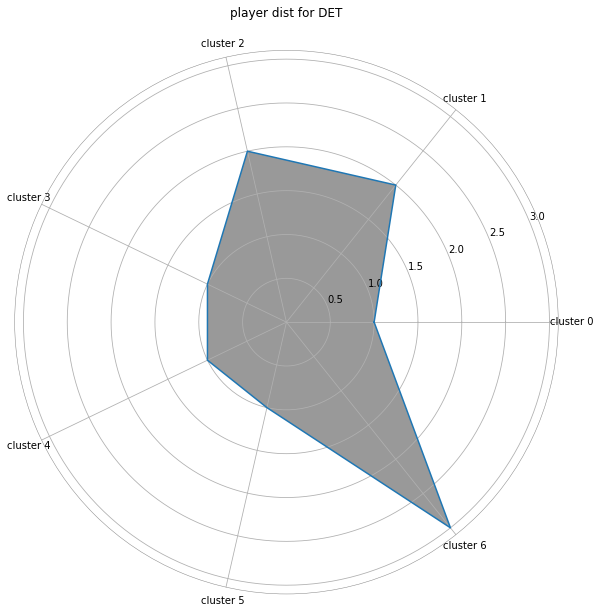

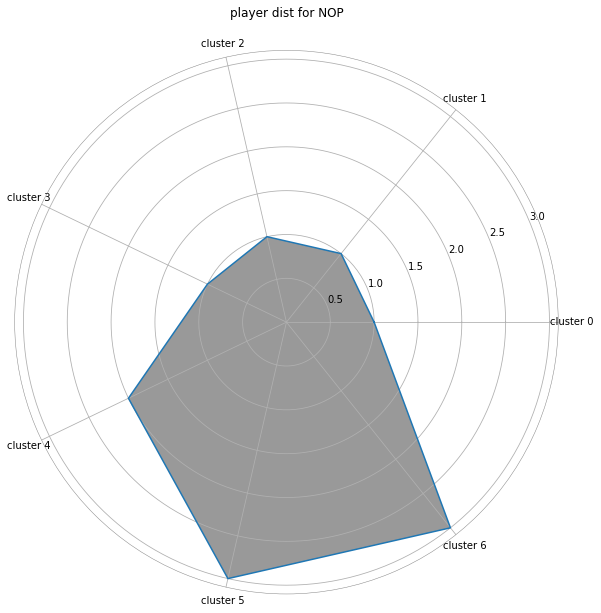

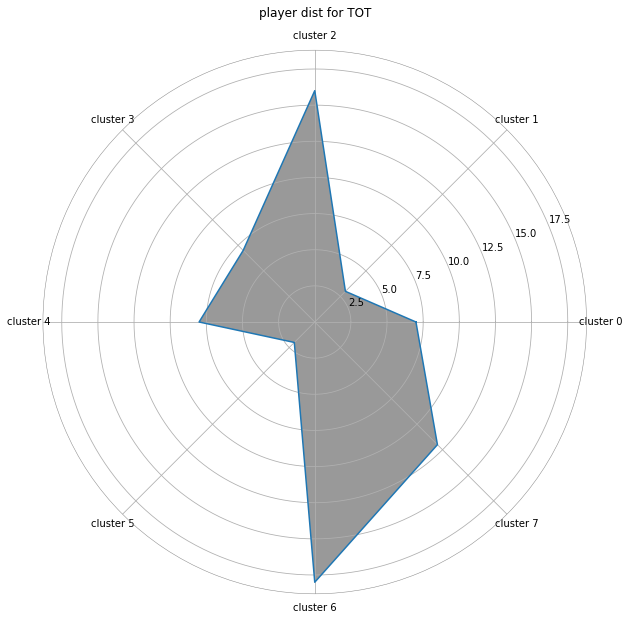

In [70]:
team_list = player_df.team_id.unique()
for team in team_list:
    plot_team(team)